# 1) Extract data of Toronto neighborhoods from Wikipedia. 

- Clean and display the top 10 rows along with shape head 
- Import Libraries Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

In [33]:
# importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed')

Packages installed


In [38]:
#Extracting data from the URL. Used old version of Wiki: 18:01, 8 March 2021 because a new one has another format..
url='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [39]:
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [40]:
df = pd.read_html(table_str)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [41]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [42]:
#renaming the colomn for better reading
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [45]:
#Dropping "Not assigned"
df = df_dropna

In [44]:
#Displaying first 5 rows 
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [46]:
#Grouping data based on "Borough"
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [47]:
# Checking if there are neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

,Borough,PostalCode,Neighbourhood


In [48]:
#adding the Latitude and Longitudes (LL) of each specific location
df = df_grouped

In [50]:
print('The DataFrame shape is', df.shape)

The DataFrame shape is (103, 3)


*the dataframe should be group by the Postal code, ending with a dataframe with 103 rows.*

# 2) Latitudes and Longitudes corresponding to the different PostalCodes

In [51]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [52]:
# Merging data from two tables
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,Borough,PostalCode,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [54]:
# finding how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
Toronto/York         1
West Toronto         6
York                 4
Name: Neighbourhood, dtype: int64

In [55]:
#finding all the neighborhoods of Toronto
df_toronto = df
df_toronto.head()

,Borough,PostalCode,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [56]:
#Create list with the boroughs
boroughs = df_toronto['Borough'].unique().tolist()

In [57]:
#Obtaining LL coordinates of Toronto itself
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.3971529116505


In [58]:
# color categorization of each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [60]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# adding markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

In [61]:
CLIENT_ID = '4510O2EFHUUWKW4WLHQJT2BUYYKD10YZ53DSL1XLQH2IIZES' # your Foursquare ID
CLIENT_SECRET = 'RTMAUAZW4Y0XDJA4PAUAHH32T5D5EHKWVT3VHTB0KG14M22O' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


In [67]:
df.loc[3, 'Neighbourhood']

'Davisville'

*We will analyze the fourth Neighborhood, Davisville*

In [69]:
law_lat = df.loc[3, 'Latitude']
law_long = df.loc[3, 'Longitude']
law_name = df.loc[3, 'Neighbourhood']


print('Latitude and longitude values of {} are {}, {}.'.format(law_name, 
                                                               law_lat, 
                                                               law_long))

Latitude and longitude values of Davisville are 43.7043244, -79.3887901.


*Now, let's get the top 100 venues that are in Davisville within a radius of 500 meters.*


In [70]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    law_lat, 
    law_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=4510O2EFHUUWKW4WLHQJT2BUYYKD10YZ53DSL1XLQH2IIZES&client_secret=RTMAUAZW4Y0XDJA4PAUAHH32T5D5EHKWVT3VHTB0KG14M22O&v=20200514&ll=43.7043244,-79.3887901&radius=500&limit=100'

In [71]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a65524d5addc57a57f2c3b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Davisville',
  'headerFullLocation': 'Davisville, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 34,
  'suggestedBounds': {'ne': {'lat': 43.7088244045, 'lng': -79.38257691798016},
   'sw': {'lat': 43.699824395499995, 'lng': -79.39500328201983}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae6ea6ef964a52082a721e3',
       'name': 'Jules Cafe Patisserie',
       'location': {'address': '617 Mt Pleasant Ave',
        'crossStreet': 'at Manor Rd E',
        'lat': 43.70413799694304,
        'lng': -79.38841260442167,
        'labeledLatLngs':

In [72]:
# extracting the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [73]:
#structuring json into pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Jules Cafe Patisserie,Dessert Shop,43.704138,-79.388413
1,Thobors Boulangerie Patisserie Café,Café,43.704514,-79.388616
2,Marigold Indian Bistro,Indian Restaurant,43.702881,-79.388008
3,XO Gelato,Dessert Shop,43.705177,-79.388793
4,Zee Grill,Seafood Restaurant,43.704985,-79.388476


In [74]:
#finding how many venues around Davisville were found
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

34 venues were returned by Foursquare.


*Exploring other neighborhoods of Toronto*

In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
#creating a new dataframe with toronto_venues (from the previous request)
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [81]:
#getting the size and shape of the dataframe
print(toronto_venues.shape)
toronto_venues.head()

(2130, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,cheltenham park,43.726670,-79.385324,Park
2,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [83]:
toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,5,5,5,5,5,5
Woodbine Heights,6,6,6,6,6,6


In [84]:
#Checking how many unique Venues there are that can be curated
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


# Analyzing each neighborhood

In [86]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighbourhood to DF
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
toronto_onehot.shape

(2130, 277)

In [89]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*neighborhood along with the top 3 most common venues:*

In [91]:
num_top_venues = 3

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0      Breakfast Spot  0.25
1  Chinese Restaurant  0.25
2              Lounge  0.25


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Gym  0.12
2  Sandwich Place  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.09
1  Coffee Shop  0.09
2     Pharmacy  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Café  0.25


----Bedford Park, Lawrence Manor East----
            venue  freq
0     Pizza Place  0.08
1  Sandwich Place  0.08
2      Restaurant  0.08


----Berczy Park----
          venue  freq
0   Coffee Shop  0.10
1  Cocktail Bar  0.07
2        Bakery  0.05


----Birch Cliff, Cliffside West----
                   venue  freq
0  General Entertainment  0.25
1        College Stadium  0.25
2                   Café  0.25


----Brockton, Parkdale Village, Exhibition 

         venue  freq
0  Coffee Shop  0.11
1        Hotel  0.07
2         Café  0.06


----University of Toronto, Harbord----
       venue  freq
0       Café  0.16
1  Bookstore  0.09
2        Bar  0.06


----Victoria Village----
                   venue  freq
0            Coffee Shop   0.2
1           Hockey Arena   0.2
2  Portuguese Restaurant   0.2


----West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale----
               venue  freq
0             Bakery   0.5
1          Gift Shop   0.5
2  Accessories Store   0.0


----Westmount----
            venue  freq
0     Pizza Place  0.25
1  Discount Store  0.12
2     Coffee Shop  0.12


----Weston----
               venue  freq
0               Park  0.67
1  Convenience Store  0.33
2  Accessories Store  0.00


----Wexford, Maryvale----
                       venue  freq
0  Middle Eastern Restaurant  0.29
1             Sandwich Place  0.14
2              Shopping Mall  0.14


----Willowdale, Newtonbrook----
                

In [92]:
#converting into pandas

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [93]:
#top 10 venues for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Chinese Restaurant,Lounge,Latin American Restaurant,Accessories Store,Monument / Landmark,Museum,Movie Theater,Motel,Moroccan Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Sandwich Place,Coffee Shop,Pub,Playground,Pharmacy,Other Great Outdoors,Metro Station,Mexican Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Diner,Mobile Phone Shop,Shopping Mall,Fried Chicken Joint,Frozen Yogurt Shop,Sandwich Place,Supermarket
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Accessories Store,Movie Theater,Music Venue,Music Store,Museum,Motel
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Greek Restaurant,Fast Food Restaurant,Butcher,Pharmacy,Café
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pharmacy,Concert Hall
6,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Accessories Store,Moroccan Restaurant,Music Store,Museum,Movie Theater,Motel
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Climbing Gym,Gym,Bar,Nightclub,Bakery,Furniture / Home Store,Restaurant
8,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Comic Shop,Recording Studio,Restaurant,Farmers Market,Fast Food Restaurant,Skate Park,Burrito Place
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boutique,Boat or Ferry,Harbor / Marina,Sculpture Garden,Bar,Airport Gate,Airport Food Court


# Clustering neighbourhoods

In [94]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Chinese Restaurant,Lounge,Latin American Restaurant,Accessories Store,Monument / Landmark,Museum,Movie Theater,Motel,Moroccan Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Sandwich Place,Coffee Shop,Pub,Playground,Pharmacy,Other Great Outdoors,Metro Station,Mexican Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Diner,Mobile Phone Shop,Shopping Mall,Fried Chicken Joint,Frozen Yogurt Shop,Sandwich Place,Supermarket
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Accessories Store,Movie Theater,Music Venue,Music Store,Museum,Motel
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Greek Restaurant,Fast Food Restaurant,Butcher,Pharmacy,Café
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pharmacy,Concert Hall
6,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Accessories Store,Moroccan Restaurant,Music Store,Museum,Movie Theater,Motel
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Climbing Gym,Gym,Bar,Nightclub,Bakery,Furniture / Home Store,Restaurant
8,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Comic Shop,Recording Studio,Restaurant,Farmers Market,Fast Food Restaurant,Skate Park,Burrito Place
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boutique,Boat or Ferry,Harbor / Marina,Sculpture Garden,Bar,Airport Gate,Airport Food Court


In [96]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = toronto_grouped.drop(['Neighbourhood'], axis=1)

kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [97]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [98]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

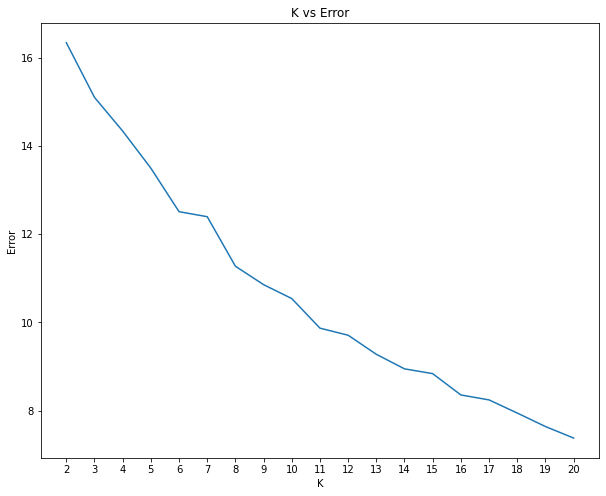

In [99]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

*from the plot we see that K=7 is the best choise*

In [104]:
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Borough,PostalCode,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,1.0,Park,Bus Line,Swim School,Accessories Store,Monument / Landmark,Museum,Movie Theater,Motel,Moroccan Restaurant,Molecular Gastronomy Restaurant
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.0,Breakfast Spot,Food & Drink Shop,Park,Hotel,Gym / Fitness Center,Sandwich Place,Dance Studio,Department Store,Accessories Store,Moroccan Restaurant
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.0,Clothing Store,Cosmetics Shop,Coffee Shop,Yoga Studio,Diner,Café,Chinese Restaurant,Seafood Restaurant,Restaurant,Rental Car Location
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.0,Pizza Place,Sandwich Place,Dessert Shop,Gym,Café,Sushi Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Farmers Market
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,1.0,Tennis Court,Park,Modern European Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Accessories Store


In [106]:
toronto_merged.tail()

,Borough,PostalCode,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,West Toronto,M6S,"Runnymede, Swansea",43.651571,-79.484450,0.0,Pizza Place,Coffee Shop,Café,Italian Restaurant,Sushi Restaurant,Pub,Bar,Bookstore,Smoothie Shop,Burrito Place
99,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,0.0,Field,Hockey Arena,Park,Trail,Accessories Store,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant
100,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,1.0,Park,Women's Store,Pool,Accessories Store,Modern European Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
101,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,0.0,Sandwich Place,Discount Store,Fast Food Restaurant,Fried Chicken Joint,Monument / Landmark,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant
102,York,M9N,Weston,43.706876,-79.518188,4.0,Park,Convenience Store,Accessories Store,Molecular Gastronomy Restaurant,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark


In [107]:
#Invalid types of Clusters or Venues? 
toronto_drop = toronto_merged[toronto_merged.Cluster_Labels != 'NaN'].reset_index(drop=True)
toronto_merged.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

# Visualization

In [110]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.75).add_to(map_clusters)
       
map_clusters

# Cluster #1

In [111]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4P,0.0,Breakfast Spot,Food & Drink Shop,Park,Hotel,Gym / Fitness Center,Sandwich Place,Dance Studio,Department Store,Accessories Store,Moroccan Restaurant
2,M4R,0.0,Clothing Store,Cosmetics Shop,Coffee Shop,Yoga Studio,Diner,Café,Chinese Restaurant,Seafood Restaurant,Restaurant,Rental Car Location
3,M4S,0.0,Pizza Place,Sandwich Place,Dessert Shop,Gym,Café,Sushi Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Farmers Market
5,M4V,0.0,Coffee Shop,Bagel Shop,Fried Chicken Joint,Sandwich Place,Light Rail Station,Sushi Restaurant,Restaurant,Supermarket,Liquor Store,Pub
6,M5N,0.0,Fast Food Restaurant,Home Service,Garden,Accessories Store,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
...,...,...,...,...,...,...,...,...,...,...,...,...
96,M6P,0.0,Mexican Restaurant,Thai Restaurant,Café,Bakery,Arts & Crafts Store,Bar,Gastropub,Fast Food Restaurant,Cajun / Creole Restaurant,Grocery Store
97,M6R,0.0,Breakfast Spot,Gift Shop,Bookstore,Dessert Shop,Dog Run,Restaurant,Movie Theater,Italian Restaurant,Eastern European Restaurant,Coffee Shop
98,M6S,0.0,Pizza Place,Coffee Shop,Café,Italian Restaurant,Sushi Restaurant,Pub,Bar,Bookstore,Smoothie Shop,Burrito Place
99,M6C,0.0,Field,Hockey Arena,Park,Trail,Accessories Store,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant


# Cluster #2

In [112]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4N,1.0,Park,Bus Line,Swim School,Accessories Store,Monument / Landmark,Museum,Movie Theater,Motel,Moroccan Restaurant,Molecular Gastronomy Restaurant
4,M4T,1.0,Tennis Court,Park,Modern European Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Accessories Store
55,M2M,1.0,Park,Accessories Store,Modern European Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Mobile Phone Shop
100,M6E,1.0,Park,Women's Store,Pool,Accessories Store,Modern European Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark


# Cluster #3

In [113]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,M8Y,2.0,Baseball Field,Accessories Store,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Modern European Restaurant,Music Venue
74,M9M,2.0,Furniture / Home Store,Baseball Field,Accessories Store,Medical Center,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant


# Cluster #4

In [115]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,M2L,3.0,Cafeteria,Accessories Store,Monument / Landmark,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant,Molecular Gastronomy Restaurant,Mediterranean Restaurant


# Cluster #5 

In [116]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,M1B,5.0,Fast Food Restaurant,Print Shop,Accessories Store,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Mobile Phone Shop


# Cluster #6 

In [117]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,M4W,6.0,Park,Playground,Trail,Modern European Restaurant,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Mobile Phone Shop
80,M1J,6.0,Playground,Molecular Gastronomy Restaurant,Music Store,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Modern European Restaurant,Medical Center
89,M1V,6.0,Playground,Intersection,Park,Molecular Gastronomy Restaurant,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Modern European Restaurant
